**Завдання**
## <font color='blue'>Створити модель згорткової мережі з трьома шарами.</font>

## <font color='blue'>Підключити **Tensorboard** і відобразити в ньому зміну розподілу ваг моделі, обчислювальний граф моделі та зміну її метрик.</font>

In [2]:
# Required libraries.
import numpy as np
import torch
import torch.nn as nn                # to load all neural network functionality
import torch.optim as opt
torch.set_printoptions(linewidth=120)
import torch.nn.functional as F      # add some efficiency
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

## Creating CNN Model

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        # It is output layer.
        self.fc3 = nn.Linear(in_features=60, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Flatten all dimensions except batch.
        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Connect to the output layer.
        x = self.fc3(x)

        return x

## Downloading a dataset and splitting into a train and a test set

In [5]:
# Splitting into a train.
train_set = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transforms.ToTensor()
    )

train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=100,
                                           shuffle=True)


# Splitting into a test.
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100,
                                         shuffle=False)


print('Train', train_set)
print('=======' * 5)
print('Test', test_set)

Train Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Test Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


## Visualisation the data

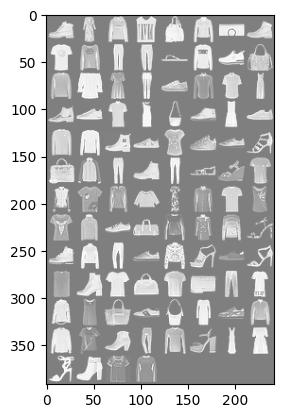

Ankle boot, Dress, Coat , Shirt, Bag  


In [7]:
# Class names are not included, need to create them to plot the images.
# Creating a list of labels.
class_names = ['T-shirt/top', 'Trouser', 'Pullover',
               'Dress', 'Coat','Sandal', 'Shirt',
               'Sneaker', 'Bag', 'Ankle boot']



# The iterator to iterate images.
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()


# Get some random training images.
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Displaying images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(', '.join(f'{class_names[labels[j]]:5s}' for j in range(5)))

## Creating a Summary Writer instance

In [8]:
# Instantiate SummaryWriter.
t_board = SummaryWriter()
model = CNN()
images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)
t_board.add_image('images', grid)
t_board.add_graph(model, images)
t_board.close()